In [ ]:
import sys
# sys.path.append('./src') #link to GTL libraries
import src.guided_transfer_learning as gtl

In [ ]:
#######################################
# GTL Notebook
import torch
import matplotlib.pyplot as plt



###########
# Bert from scratch
from dataclasses import dataclass
from typing import Tuple, TypeVar

import torch
import torch.nn as nn
from torch.nn import functional as F



## Prepare Functions

## Google BERT: Model Architecture
Initial source of code:
- https://medium.com/@alexmriggio/bert-for-sequence-classification-from-scratch-code-and-theory-fb88053800fa
- https://github.com/alexriggio/BERT-LoRA-TensorRT


- BERT paper: https://arxiv.org/abs/1810.04805


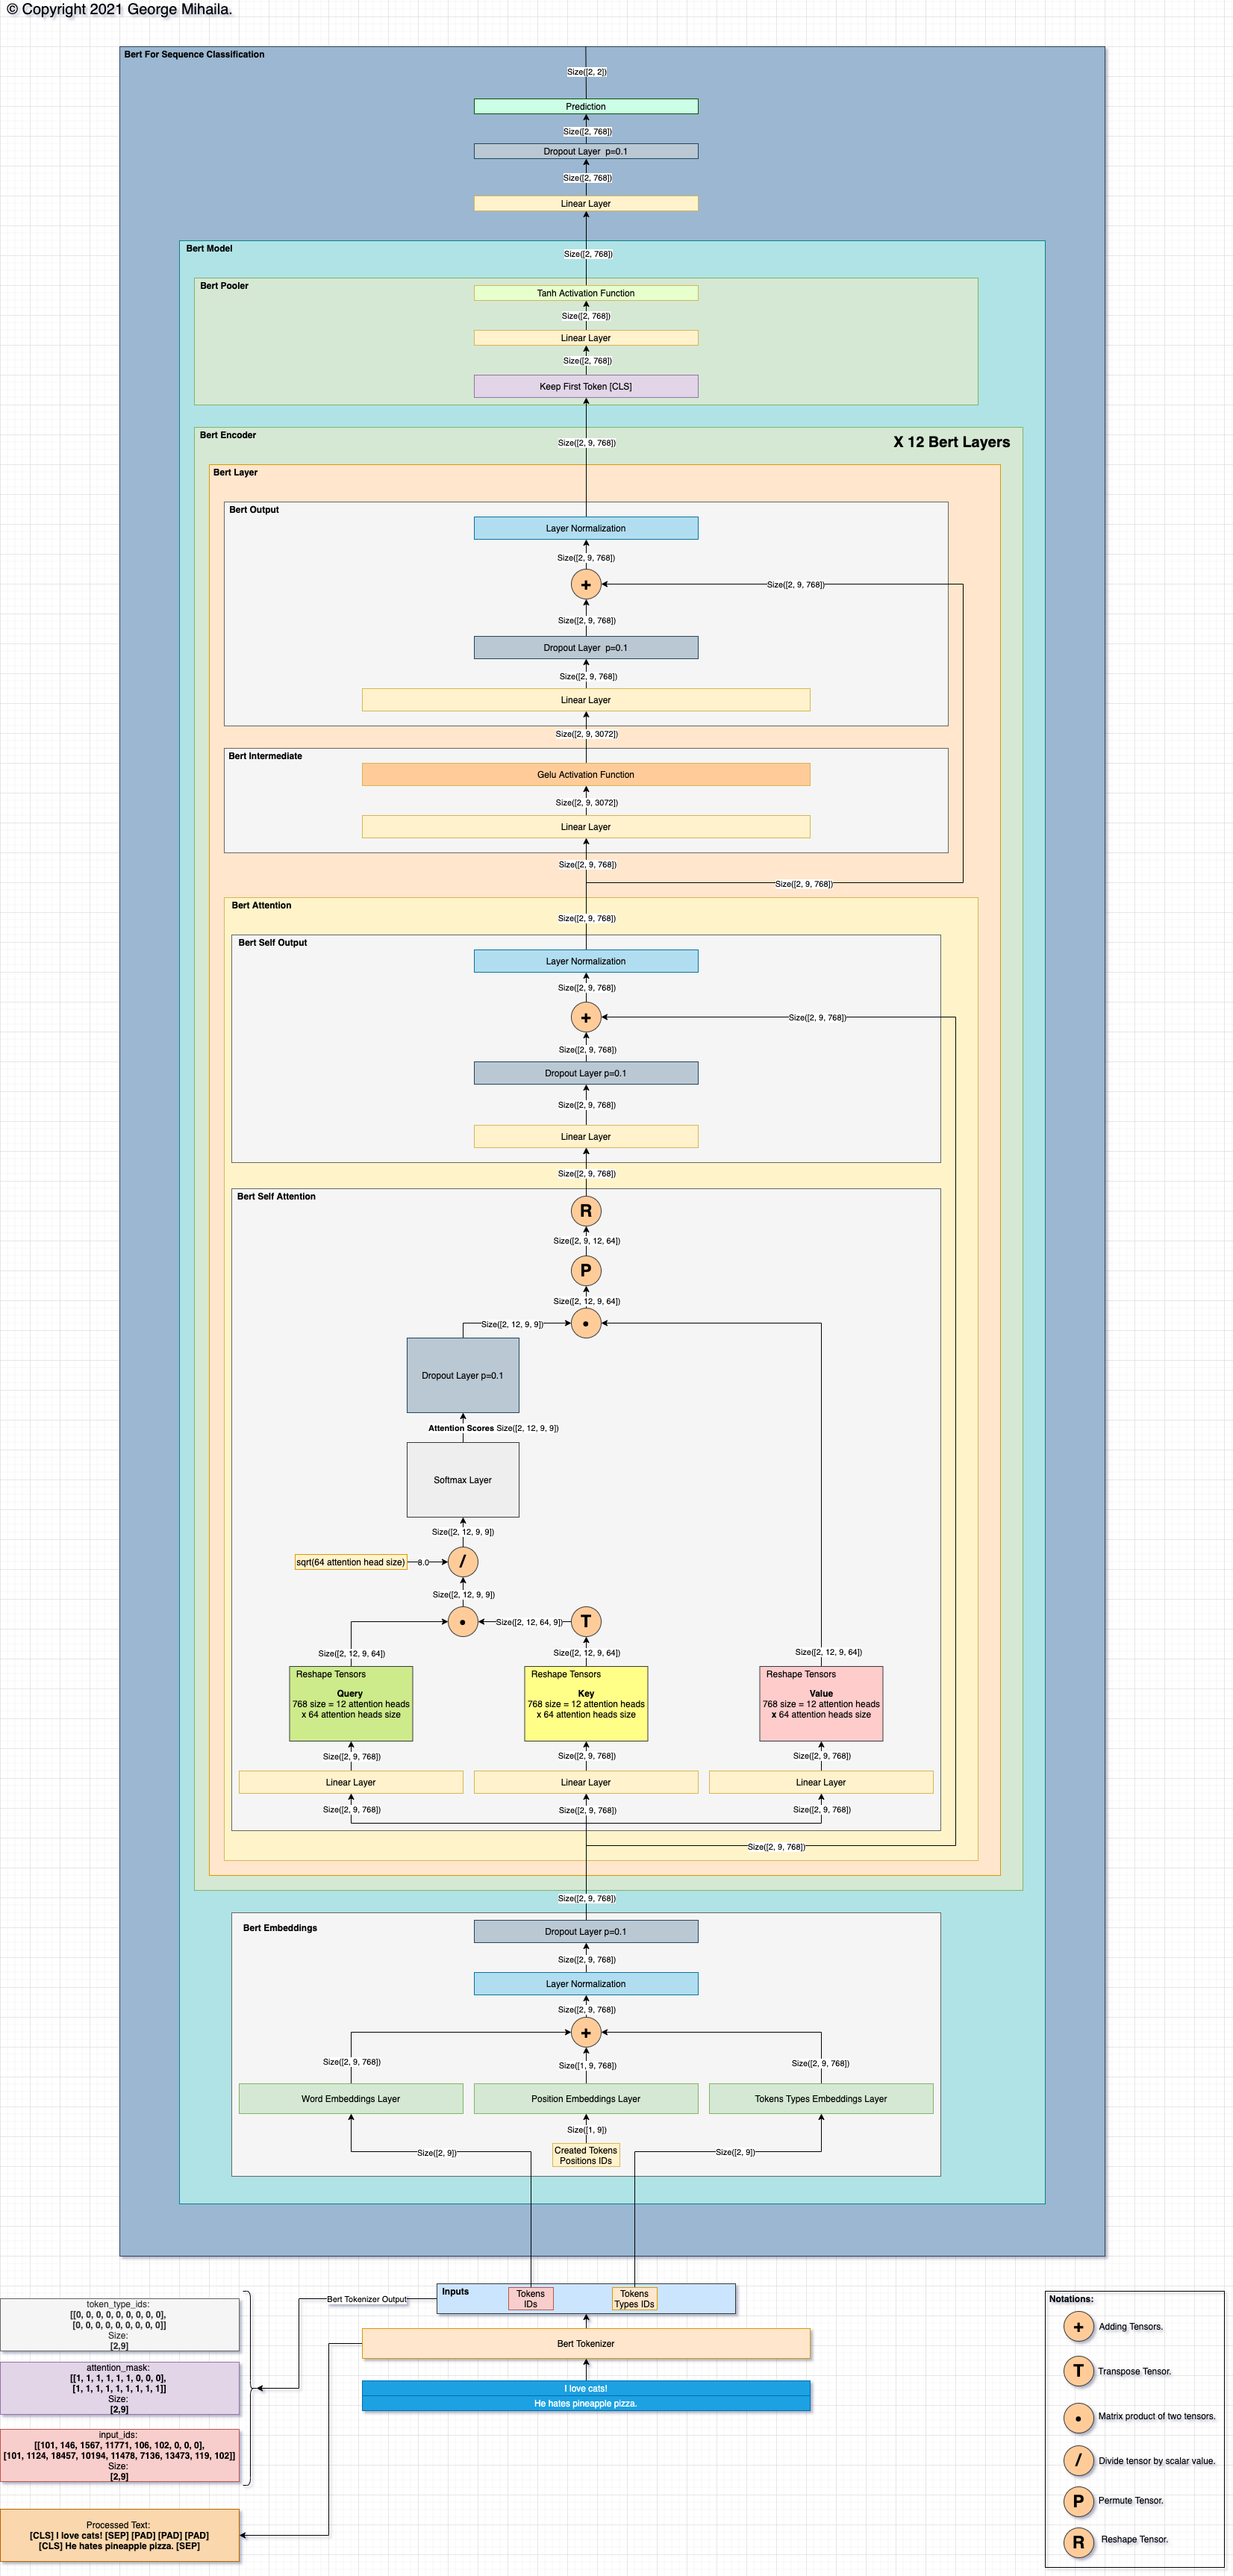

- source of image: https://raw.githubusercontent.com/gmihaila/ml_things/master/notebooks/pytorch/bert_inner_workings/bert_inner_workings.png

#### Tokenizer: Hugging Face BERT Tokenizer

- Embedding:

In [ ]:
@dataclass
class BertConfig:
    """
    Configuration class for BERT model.

    Attr:
        max_seq_length: int = Integer representing the maximum sequence length the model can process. 
        vocab_size: int = Integer representing the number of unique tokens in the vocabulary.
        n_layers: int = Integr representing the number of BERT layers in the encoder.
        n_heads: Tuple[int] = Tuple of integrs representing the number of attention heads in each layer of the model.
            e.g. n_heads[i] is the number of heads in the i-th layer.
        emb_size: int = Integer representing the length of the embedding vectors
        intermediate_size: int = Integer representing the length the vector the embedding gets projected to in the intermediate module. 
        dropout: float = Float representing the dropout applied throughout the model.
        n_classes: int = Integer representing the number of classes the model predicts.
        layer_norm_eps: float = Float representing the epsilon value used in LayerNorm. 
        pad_token_id: int = Integer representing the token id for the padding token.
        return_pooler_output: bool = Bool that if True returns the pooled output from the encoder (in addition to the logits).
    """   
    max_seq_length: int = 512 
    vocab_size: int = 30522
    n_layers: int = 12
    n_heads: Tuple[int] = (12,) * n_layers # type: ignore
    emb_size: int = 768
    intermediate_size: int = emb_size * 4
    dropout: float = 0.1
    n_classes: int = 2
    layer_norm_eps: float = 1e-12
    pad_token_id: int = 103
    return_pooler_output: bool = False

In [ ]:
print('BertConfig.n_heads: ', BertConfig.n_heads)
print('BertConfig.intermediate_size: ', BertConfig.intermediate_size)
print('BertConfig.n_classes: ', BertConfig.n_classes)


BertConfig.n_heads:  (12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12)
BertConfig.intermediate_size:  3072
BertConfig.n_classes:  2


In [ ]:
class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.word_embeddings = nn.Embedding(config.vocab_size, config.emb_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_seq_length, config.emb_size)
        self.token_type_embeddings = nn.Embedding(2, config.emb_size)
        self.LayerNorm = nn.LayerNorm(config.emb_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.dropout)
        
        # position ids (used in the pos_emb lookup table) that we do not want updated through backpropogation
        self.register_buffer("position_ids", torch.arange(config.max_seq_length).expand((1, -1)))

    def forward(self, input_ids, token_type_ids):
        word_emb = self.word_embeddings(input_ids)
        pos_emb = self.position_embeddings(self.position_ids)
        type_emb = self.token_type_embeddings(token_type_ids)

        emb = word_emb + pos_emb + type_emb
        emb = self.LayerNorm(emb)
        emb = self.dropout(emb)

        return emb

#### Encoder:

- Multi-Headed Self-Attention:

In [ ]:
class BertSelfAttention(nn.Module):
    def __init__(self, config, layer_i):
        super().__init__()
        self.config = config
        self.n_heads = config.n_heads[layer_i]
        self.head_size = config.emb_size // self.n_heads
        self.query = nn.Linear(config.emb_size, config.emb_size)
        self.key = nn.Linear(config.emb_size, config.emb_size)
        self.value = nn.Linear(config.emb_size, config.emb_size)
        self.dropout = nn.Dropout(config.dropout)


    def forward(self, emb, att_mask):
        B, T, C = emb.shape  # batch size, sequence length, embedding size   
    
        q = self.query(emb).view(B, T, self.n_heads, self.head_size).transpose(1, 2)
        k = self.key(emb).view(B, T, self.n_heads, self.head_size).transpose(1, 2)
        v = self.value(emb).view(B, T, self.n_heads, self.head_size).transpose(1, 2)
        
        weights = q @ k.transpose(-2, -1) * self.head_size**-0.5
        
        # set the pad tokens to -inf so that they equal zero after softmax
        if att_mask != None:
            att_mask = (att_mask > 0).unsqueeze(1).repeat(1, att_mask.size(1), 1).unsqueeze(1)
            weights = weights.masked_fill(att_mask == 0, float('-inf'))

        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        
        emb_rich = weights @ v
        emb_rich = emb_rich.transpose(1, 2).contiguous().view(B, T, C)
        
        return emb_rich


In [ ]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.emb_size, config.emb_size)
        self.dropout = nn.Dropout(config.dropout)
        self.LayerNorm = nn.LayerNorm(config.emb_size, eps=config.layer_norm_eps)
        
    def forward(self, emb_rich, emb):
        x = self.dense(emb_rich)
        x = self.dropout(x)
        x = x + emb
        out = self.LayerNorm(x)

        return out

In [ ]:
class BertAttention(nn.Module):
    def __init__(self, config, layer_i):
        super().__init__()
        self.self = BertSelfAttention(config, layer_i)
        self.output = BertSelfOutput(config)

    def forward(self, emb, att_mask):
        emb_rich = self.self(emb, att_mask)
        out = self.output(emb_rich, emb)

        return out

- Position-Wise Feed-Forward Network

In [ ]:
class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.emb_size, config.intermediate_size)
        self.gelu = nn.GELU() 

    def forward(self, att_out):
        x = self.dense(att_out)
        out = self.gelu(x)

        return out


class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.emb_size)
        self.dropout = nn.Dropout(config.dropout)
        self.LayerNorm = nn.LayerNorm(config.emb_size, eps=config.layer_norm_eps) 

    def forward(self, intermediate_out, att_out):
        x = self.dense(intermediate_out)
        x = self.dropout(x)
        x = x + att_out
        out = self.LayerNorm(x)

        return out 

- BertLayer:

In [ ]:
class BertLayer(nn.Module):
    def __init__(self, config, layer_i):
        super().__init__()
        self.attention = BertAttention(config, layer_i)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config) 

    def forward(self, emb, att_mask):
        att_out = self.attention(emb, att_mask)
        intermediate_out = self.intermediate(att_out)
        out = self.output(intermediate_out, att_out)

        return out

- BertEncoder:

In [ ]:
class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(config, layer_i) for layer_i in range(config.n_layers)])
    
    def forward(self, emb, att_mask):
        for bert_layer in self.layer:
            emb = bert_layer(emb, att_mask)
        return emb

- Pooler:

In [ ]:
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.emb_size, config.emb_size)
        self.tanh = nn.Tanh()

    def forward(self, encoder_out):
        pool_first_token = encoder_out[:, 0]
        out = self.dense(pool_first_token)
        out = self.tanh(out)
        return out

- BertModel :

In [ ]:
class BertModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)

    def forward(self, input_ids, token_type_ids, att_mask):
        emb = self.embeddings(input_ids, token_type_ids)
        out = self.encoder(emb, att_mask)
        pooled_out = self.pooler(out)
        return out, pooled_out

- Classification Head:

In [ ]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.bert = BertModel(config) 
        self.dropout = nn.Dropout(config.dropout)
        
        ############################################################ 
        ############################################################
        ## Change here number of classes config.n_classes according to the use case
        self.classifier = nn.Linear(config.emb_size, config.n_classes) 
        ################################################################
        ################################################################
        
    def forward(self, input_ids, token_type_ids, attention_mask=None):
        _, pooled_out = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_out = self.dropout(pooled_out)
        logits = self.classifier(pooled_out)
        
        if self.config.return_pooler_output:
            return pooled_out, logits        
        return logits
     
    def reduce_seq_len(self, seq_len):
        """
        Reduces the accepted sequence length of the inputs into the model.
            e.g. BERT normally accepts a maximum of 512 tokens. This can be reduced to a lesser number of tokens
                for a smaller model that requires less compute during training or inference.
             
        Args:
            seq_len: int = An integer representing the length of the sequences accepted by the model
        """
        assert seq_len <= self.config.max_seq_length, f"Sequence length must be reduced below current length of {self.config.max_seq_length}"
        self.bert.embeddings.position_embeddings.weight = nn.Parameter(self.bert.embeddings.position_embeddings.weight[:seq_len])
        self.bert.embeddings.position_ids = self.bert.embeddings.position_ids[:, :seq_len]
        print(f"Sequence length successfully reduced to {seq_len}.")
        self.config.max_seq_length = seq_len
        
    @staticmethod
    def adaptive_copy(orig_wei, new_wei):
        """
        Copies the new weights from the pretrained model into the custom model. 
        If the dimensions of the new weights are larger then it only copies the 
        portions that fit.
            
            e.g. old_weight_dim = (1 x 64), new_weight_dim = (1 x 512) 
                Replaces the old weights with the first 64 elements of the new weights.
              
        Args:
            orig_wei: torch.tensor = Torch tensor containing the weights from the custom model
            new_wei: torch.tensor = Torch tensor containing the weights from the pretrained model
        """                             
        n_dim = orig_wei.dim()
        
        with torch.no_grad():
            if n_dim == 1:
                dim1 = list(orig_wei.shape)[0]
                orig_wei.copy_(new_wei[:dim1])
            elif n_dim == 2:
                dim1, dim2 = list(orig_wei.shape)
                orig_wei.copy_(new_wei[:dim1, :dim2])
            elif n_dim == 3:
                dim1, dim2, dim3 = list(orig_wei.shape)
                orig_wei.copy_(new_wei[:dim1, :dim2, :dim3])
        
    @classmethod
    def from_pretrained(cls, model_type, config_args=None, adaptive_weight_copy=False):
        """
        Instantiates the BERT model and loads the weights from a compatible hugging face model.
               
        Args:
            cls: None = Refers to the class itself, similar to how self refers to the instance of the class.
            model_type: str = Model name (hugging face) or local path 
                e.g. 'bert-base-uncased' or './path/bert-base-uncased.pth'
            config_args: dict = Dictionary having all or less of the keys found in BertConfig()
                e.g. config_args = dict(max_seq_length=512, vocab_size=30522, n_classes=2) 
            adaptive_weights: bool = Boolean that when true, if the weight dimensions are smaller in the custom model, 
                                     it will copy over the the portions of the weights that fit. When false
                                     it will throw an error if mismatch in shape weights.
                
        Returns:
            torch.nn.Module: A pytorch model
        """                             
        from transformers import BertForSequenceClassification as HFBertForSequenceClassification
        
        print(f"Loading weights from pretrained model: {model_type}")
        
        if config_args:
            config = BertConfig(**config_args)
        else:
            config = BertConfig()
        
        # init custom model
        model = cls(config)        
        sd = model.state_dict()
        sd_keys = sd.keys()
        
        # init huggingface/transformers model
        model_hf = HFBertForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_type, num_labels=config.n_classes)
        sd_hf = model_hf.state_dict()
        sd_keys_hf = sd_hf.keys()

        # Check that all keys match between the state dictionary of the custom and pretrained model
        assert len(sd_keys_hf) == len(sd_keys), (
            f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}. "
            "Try using transformers==4.28.1 as this version is known to be compatible."
        )
        
        # Replace weights in the custom model with the weights from the pretrained model
        for k in sd_keys_hf:
            
            # copy over weights if they are the same shape
            if not adaptive_weight_copy:
                
                # Check that the shape of the corresponding weights are the same between the two models
                assert sd_hf[k].shape == sd[k].shape, f"Shape mismatch: {k} --> (hf vs custom) ({sd_hf[k].shape} vs {sd[k].shape})"  
                
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
            
            # adaptively copy over weights by cropping them if the dimensions are larger
            else:
                with torch.no_grad():
                    cls.adaptive_copy(sd[k], sd_hf[k])                  
        return model

#### Fine Tuning:
source: https://github.com/alexriggio/BERT-LoRA-TensorRT/blob/main/notebooks/fine_tuning.ipynb

In [ ]:
# add python path to include src directory
# import sys
# sys.path.insert(0, '../src')

# standard library imports
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple
import math

# related third party imports
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

local library specific imports
from bert_from_scratch import BertForSequenceClassification as MyBertForSequenceClassification
from lora_from_scratch import (
    LinearLoRA,
    create_lora,
    add_lora_layers,
    freeze_model,
    unfreeze_model,
    create_linear,
    merge_lora_layers,
)

- Data Preprocessing:

In [ ]:
def collate_fn(batch):
    """ Instructs how the DataLoader should process the data into a batch"""
    
    text = [item['text'] for item in batch]
    tabular = torch.stack([torch.tensor(item['tabular']) for item in batch])
    labels = torch.stack([torch.tensor(item['label']) for item in batch])

    return {'text': text, 'tabular': tabular, 'label': labels}


df = pd.read_csv("../data/train-sample.csv")

# dict mapping strings to integers
string_to_int = {
    'open': 0,
    'not a real question': 1,
    'off topic': 1,
    'not constructive': 1,
    'too localized': 1
}

# add new features to dataframe
df['OpenStatusInt'] = df['OpenStatus'].map(string_to_int)  # convert class strings to integers
df['BodyLength'] = df['BodyMarkdown'].apply(lambda x: len(x.split(" ")))  # number of words in body text
df['TitleLength'] = df['Title'].apply(lambda x: len(x.split(" ")))  # number of words in title text
df['TitleConcatWithBody'] = df.apply(lambda x: x.Title +  " " + x.BodyMarkdown, axis=1)  # combine title and body text
df['NumberOfTags'] = df.apply(
    lambda x: len([x[col] for col in ['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5'] if not pd.isna(x[col])]), 
    axis=1,
)  # number of tags
df['PostCreationDate'] = pd.to_datetime(df['PostCreationDate'])  # convert string to Timedelta object
df['OwnerCreationDate'] = pd.to_datetime(df['OwnerCreationDate'], format='mixed')  # convert string to Timedelta object
df['DayDifference'] = (df['PostCreationDate'] - df['OwnerCreationDate']).dt.days  # days between account creation and post creation 

# list of col names with tabular data 
tabular_feature_list = [
    'ReputationAtPostCreation',  
    'BodyLength', 
    'TitleLength', 
    'NumberOfTags',
    'DayDifference',
]

# place the desired data from the dataframe into a dictionary
data_dict = {
    'text': df.TitleConcatWithBody.tolist(),
    'tabular': df[tabular_feature_list].values,
    'label': df.OpenStatusInt.tolist(),
}

# load data into hugging face dataset object
dataset_stackoverflow = Dataset.from_dict(data_dict)

# define the indices at which to split the dataset into train/validation/test
n_samples = len(dataset_stackoverflow)
split_idx1 = int(n_samples * 0.8)
split_idx2 = int(n_samples * 0.9)

# shuffle the dataset
shuffled_dataset = dataset_stackoverflow.shuffle(seed=42)

# split dataset training/validation/test
train_dataset = shuffled_dataset.select(range(split_idx1))
val_dataset = shuffled_dataset.select(range(split_idx1, split_idx2))
test_dataset = shuffled_dataset.select(range(split_idx2, n_samples))

# calculate mean and std of each tabular feature
mean_train = torch.mean(torch.tensor(train_dataset['tabular'], dtype=torch.float32), dim=0)
std_train = torch.std(torch.tensor(train_dataset['tabular'], dtype=torch.float32), dim=0)

# define a function to apply standard scaling to the tabular data
def standard_scale(example):
    example['tabular'] = (torch.tensor(example['tabular']) - mean_train) / std_train
    return example

# apply the standard scaling function to the tabular features
train_dataset = train_dataset.map(standard_scale)
val_dataset = val_dataset.map(standard_scale)
test_dataset = test_dataset.map(standard_scale)

# load the datasets into a dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

- Trainer Class: 

In [ ]:
class BertTrainer:
    """ A training and evaluation loop for PyTorch models with a BERT like architecture. """
    
    
    def __init__(
        self, 
        model,
        tokenizer,
        train_dataloader,
        eval_dataloader=None,
        epochs=1,
        lr=5e-04,
        output_dir='./',
        output_filename='model_state_dict.pt',
        save=False,
        tabular=False,
    ):
        """
        Args:
            model: torch.nn.Module: = A PyTorch model with a BERT like architecture,
            tokenizer: = A BERT tokenizer for tokenizing text input,
            train_dataloader: torch.utils.data.DataLoader = 
                A dataloader containing the training data with "text" and "label" keys (optionally a "tabular" key),
            eval_dataloader: torch.utils.data.DataLoader = 
                A dataloader containing the evaluation data with "text" and "label" keys (optionally a "tabular" key),
            epochs: int = An integer representing the number epochs to train,
            lr: float = A float representing the learning rate for the optimizer,
            output_dir: str = A string representing the directory path to save the model,
            output_filename: string = A string representing the name of the file to save in the output directory,
            save: bool = A boolean representing whether or not to save the model,
            tabular: bool = A boolean representing whether or not the BERT model is modified to accept tabular data,
        """
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.tokenizer = tokenizer
        self.train_dataloader = train_dataloader
        self.eval_dataloader = eval_dataloader
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        self.loss_fn = nn.CrossEntropyLoss()
        self.output_dir = output_dir
        self.output_filename = output_filename
        self.save = save
        self.eval_loss = float('inf')  # tracks the lowest loss so as to only save the best model  
        self.epochs = epochs
        self.epoch_best_model = 0  # tracks which epoch the lowest loss is in so as to only save the best model
        self.tabular = tabular
    
    def train(self, evaluate=False):
        """ Calls the batch iterator to train and optionally evaluate the model."""
        for epoch in range(self.epochs):
            self.iteration(epoch, self.train_dataloader)
            if evaluate and self.eval_dataloader is not None:
                self.iteration(epoch, self.eval_dataloader, train=False)

    def evaluate(self):
        """ Calls the batch iterator to evaluate the model."""
        epoch=0
        self.iteration(epoch, self.eval_dataloader, train=False)
    
    def iteration(self, epoch, data_loader, train=True):
        """ Iterates through one epoch of training or evaluation"""
        
        # initialize variables
        loss_accumulated = 0.
        correct_accumulated = 0
        samples_accumulated = 0
        preds_all = []
        labels_all = []
        
        self.model.train() if train else self.model.eval()
        
        # progress bar
        mode = "train" if train else "eval"
        batch_iter = tqdm.tqdm(
            enumerate(data_loader),
            desc=f"EP ({mode}) {epoch}",
            total=len(data_loader),
            bar_format="{l_bar}{r_bar}"
        )
        #####################################################
        ################
        # iterate through batches of the dataset
        for i, batch in batch_iter:

            # tokenize data
            batch_t = self.tokenizer(
                batch['text'],
                padding='max_length', 
                max_length=512, 
                truncation=True,
                return_tensors='pt', 
            )
            batch_t = {key: value.to(self.device) for key, value in batch_t.items()}
            batch_t["input_labels"] = batch["label"].to(self.device)
            batch_t["tabular_vectors"] = batch["tabular"].to(self.device)

            # forward pass - include tabular data if it is a tabular model
            if self.tabular:
                logits = self.model(
                    input_ids=batch_t["input_ids"], 
                    token_type_ids=batch_t["token_type_ids"], 
                    attention_mask=batch_t["attention_mask"],
                    tabular_vectors=batch_t["tabular_vectors"],
                )   
            
            else:
                logits = self.model(
                    input_ids=batch_t["input_ids"], 
                    token_type_ids=batch_t["token_type_ids"], 
                    attention_mask=batch_t["attention_mask"],
                )

            # calculate loss
            loss = self.loss_fn(logits, batch_t["input_labels"])
    
            # compute gradient and and update weights
            if train:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            # calculate the number of correct predictions
            preds = logits.argmax(dim=-1)
            correct = preds.eq(batch_t["input_labels"]).sum().item()
            
            # accumulate batch metrics and outputs
            loss_accumulated += loss.item()
            correct_accumulated += correct
            samples_accumulated += len(batch_t["input_labels"])
            preds_all.append(preds.detach())
            labels_all.append(batch_t['input_labels'].detach())
        
        # concatenate all batch tensors into one tensor and move to cpu for compatibility with sklearn metrics
        preds_all = torch.cat(preds_all, dim=0).cpu()
        labels_all = torch.cat(labels_all, dim=0).cpu()
        
        # metrics
        accuracy = accuracy_score(labels_all, preds_all)
        precision = precision_score(labels_all, preds_all, average='macro')
        recall = recall_score(labels_all, preds_all, average='macro')
        f1 = f1_score(labels_all, preds_all, average='macro')
        avg_loss_epoch = loss_accumulated / len(data_loader)
        
        # print metrics to console
        print(
            f"samples={samples_accumulated}, \
            correct={correct_accumulated}, \
            acc={round(accuracy, 4)}, \
            recall={round(recall, 4)}, \
            prec={round(precision,4)}, \
            f1={round(f1, 4)}, \
            loss={round(avg_loss_epoch, 4)}"
        )    
        
        # save the model if the evaluation loss is lower than the previous best epoch 
        if self.save and not train and avg_loss_epoch < self.eval_loss:
            
            # create directory and filepaths
            dir_path = Path(self.output_dir)
            dir_path.mkdir(parents=True, exist_ok=True)
            file_path = dir_path / f"{self.output_filename}_epoch_{epoch}.pt"
            
            # delete previous best model from hard drive
            if epoch > 0:
                file_path_best_model = dir_path / f"{self.output_filename}_epoch_{self.epoch_best_model}.pt"
                !rm -f $file_path_best_model
            
            # save model
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict()
            }, file_path)
            
            # update the new best loss and epoch
            self.eval_loss = avg_loss_epoch
            self.epoch_best_model = epoch

- Fine-Tuning:

In [ ]:
######################################################
#### BERT-base ###################################### 
######################################################
#  
# # load tokenizer and pretrained model
tokenizer_base = BertTokenizer.from_pretrained('bert-base-uncased')
bert_base = MyBertForSequenceClassification.from_pretrained(
    model_type='bert-base-uncased',
    config_args={"vocab_size": 30522, "n_classes": 2}  # these are default configs but just added for explicity
)

In [ ]:
###################################################### 
#### Fine-Tune ###################################### 
######################################################
#bert base
trainer_bert_base = BertTrainer(
    bert_base,
    tokenizer_base,
    lr=5e-06,
    epochs=5,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    output_dir='../models/bert_base_fine_tuned',
    output_filename='bert_base',
    save=True,
)

trainer_bert_base.train(evaluate=True)



In [ ]:
###################################################### 
#### Evaluate ###################################### 
######################################################
# copy weights from the saved fine-tuned model
state_dict = torch.load('../models/bert_base_fine_tuned/bert_base_epoch_1.pt')  # replace with .pt file from models dir
bert_base.load_state_dict(state_dict["model_state_dict"])

# trainer
trainer_bert_base = BertTrainer(
    bert_base,
    tokenizer_base,
    lr=5e-06,
    epochs=5,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    output_dir='../models/bert_base_fine_tuned',
    output_filename='bert_base',
    save=False,
)

# evaluate on test set
trainer_bert_base.evaluate()